In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acne-mini-dense/images/cm5w6ef2p0he007hw9m44eaq3.png
/kaggle/input/acne-mini-dense/images/cm60e86w206pn07fsbu0iep6p.png
/kaggle/input/acne-mini-dense/images/cm5tcutss03qz07hpdo9w48pu.png
/kaggle/input/acne-mini-dense/images/cm5uicy7j0sle07gn40qgauaf.png
/kaggle/input/acne-mini-dense/images/cm5tduybl04cl07hp5qe7hq9o.png
/kaggle/input/acne-mini-dense/images/cm5ugji6k0l5k07gnd0maaabl.png
/kaggle/input/acne-mini-dense/images/cm5w36yzx03kn07ez8xo48x7i.png
/kaggle/input/acne-mini-dense/images/cm5tzvhm202c307dzeyon60nq.png
/kaggle/input/acne-mini-dense/images/cm5u7aejk07d007k7gp8z5ylf.png
/kaggle/input/acne-mini-dense/images/cm5uhqmu80nuc07e41qhvgk22.png
/kaggle/input/acne-mini-dense/images/cm5tzn8bw033n07fqgploagcn.png
/kaggle/input/acne-mini-dense/images/cm5vukkd90eep07awdek9djeo.png
/kaggle/input/acne-mini-dense/images/cm5w3hfza00f807iu6bgfdnd3.png
/kaggle/input/acne-mini-dense/images/cm5vsxzl304ow07e1gvgsa6ic.png
/kaggle/input/acne-mini-dense/images/cm60d3x6l01if07g05rp32bq4

In [2]:
!pip install -q segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.2 MB/s eta 0:00:00


In [3]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp
from PIL import Image

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

In [4]:
import os
from sklearn.model_selection import train_test_split

# Path to dataset
image_dir = "/kaggle/input/acne-larger-set/og_images"
mask_dir = "/kaggle/input/acne-larger-set/og_masks"

# List all images and masks
images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

# Ensure paths are complete
images = [os.path.join(image_dir, img) for img in images]
masks = [os.path.join(mask_dir, msk) for msk in masks]

# Split data (80% train, 20% validation)
train_images, valid_images, train_masks, valid_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)



In [5]:
class CFG:
    seed          = 42
    debug         = False # set debug=False for Full Training
    exp_name      = 'baseline'
    comment       = 'unet-efficientnet_b1-512x512'
    output_dir    = './'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 2
    valid_bs      = 1
    img_size      = [512, 512]
    epochs        = 30
    n_accumulate  = max(1, 64//train_bs)
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(2279/(train_bs*n_accumulate)*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_fold        = 5
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_root = "/kaggle/input"
    train_groups = [train_images]
    valid_groups = [valid_images]
    loss_func     = "DiceLoss"

    data_transforms = {
        "train": A.Compose([
            A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
            A.HorizontalFlip(p=0.5),
        ], p=1.0),
        
        "valid": A.Compose([
            A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
    }

In [6]:
# Test CFG initialization

print("CFG initialized successfully!")
print("Experiment Name:", CFG.exp_name)
print("Device:", CFG.device)


CFG initialized successfully!
Experiment Name: baseline
Device: cuda:0


In [7]:
if CFG.train_groups:
    print("Train Groups:", CFG.train_groups)
else:
    print("Train Groups are not defined!")

if CFG.valid_groups:
    print("Validation Groups:", CFG.valid_groups)
else:
    print("Validation Groups are not defined!")

Train Groups: [['/kaggle/input/acne-larger-set/og_images/cm5w3sehv024307hfemwb55ps.png', '/kaggle/input/acne-larger-set/og_images/cm5uh90ss0o7307gsfas5840h.png', '/kaggle/input/acne-larger-set/og_images/cm618uq0r0gdr07dw4m5334zj.png', '/kaggle/input/acne-larger-set/og_images/cm632tfu1022z07fx5mwbhrbk.png', '/kaggle/input/acne-larger-set/og_images/cm5wtpqhw03ew07ija834bw6y.png', '/kaggle/input/acne-larger-set/og_images/cm5w6l5q60c3m07ha3j4mf40d.png', '/kaggle/input/acne-larger-set/og_images/cm6346tua02eb07h9gncde6o3.png', '/kaggle/input/acne-larger-set/og_images/cm61860d50f5h07h2fmgz6a7a.png', '/kaggle/input/acne-larger-set/og_images/cm64gri2a0b7g07hl8yn376p3.png', '/kaggle/input/acne-larger-set/og_images/cm60fuyyi0au807cz833r1dxd.png', '/kaggle/input/acne-larger-set/og_images/cm5w3betm048s07fb7wx114b0.png', '/kaggle/input/acne-larger-set/og_images/cm5vt4hne05rp07f1ajiyfn15.png', '/kaggle/input/acne-larger-set/og_images/cm60e86w206pn07fsbu0iep6p.png', '/kaggle/input/acne-larger-set/og_i

In [8]:
from albumentations import Compose, Resize, HorizontalFlip

CFG.data_transforms = {
    "train": Compose([
        Resize(512, 512, always_apply=True),  # Ensure consistent size
        HorizontalFlip(p=0.5),
    ]),
    "valid": Compose([
        Resize(512, 512, always_apply=True),  # Ensure consistent size
    ])
}


In [9]:
cfg = CFG
import numpy as np
import albumentations as A

# Test train data transform
dummy_image = np.random.randint(0, 256, (600, 600, 3), dtype=np.uint8)  # Dummy RGB image
dummy_mask = np.random.randint(0, 2, (600, 600), dtype=np.uint8)  # Dummy binary mask

train_transform = cfg.data_transforms["train"]
valid_transform = cfg.data_transforms["valid"]

# Apply train transform
transformed = train_transform(image=dummy_image, mask=dummy_mask)
print("Transformed Train Image Shape:", transformed['image'].shape)
print("Transformed Train Mask Shape:", transformed['mask'].shape)

# Apply valid transform
transformed = valid_transform(image=dummy_image, mask=dummy_mask)
print("Transformed Valid Image Shape:", transformed['image'].shape)
print("Transformed Valid Mask Shape:", transformed['mask'].shape)


Transformed Train Image Shape: (512, 512, 3)
Transformed Train Mask Shape: (512, 512)
Transformed Valid Image Shape: (512, 512, 3)
Transformed Valid Mask Shape: (512, 512)


In [10]:

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(CFG.seed)

In [11]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [12]:
class BuildDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))

        # Apply transformations
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Convert to PyTorch tensors
        image = torch.tensor(image).permute(2, 0, 1).float()  # (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask).long()

        return image, mask


In [13]:


train_dataset = BuildDataset(train_images, train_masks, transforms=CFG.data_transforms['train'])
valid_dataset = BuildDataset(valid_images, valid_masks, transforms=CFG.data_transforms['valid'])
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False)


<ipython-input-14-9e480fbdf776>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


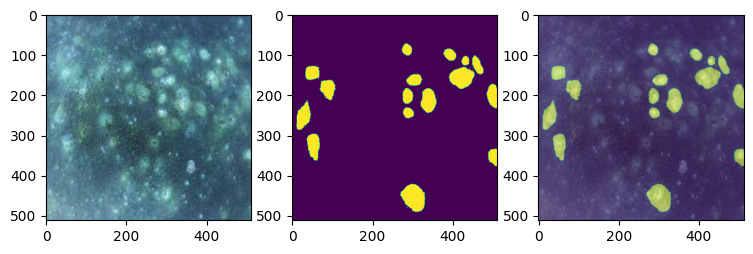

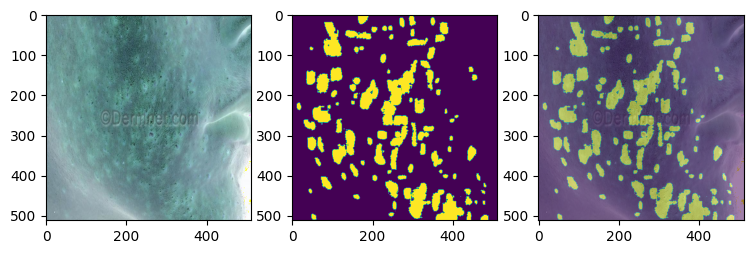

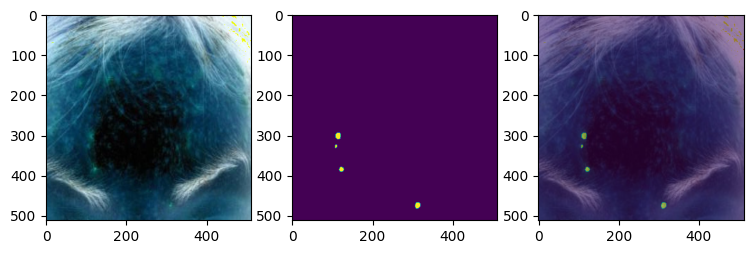

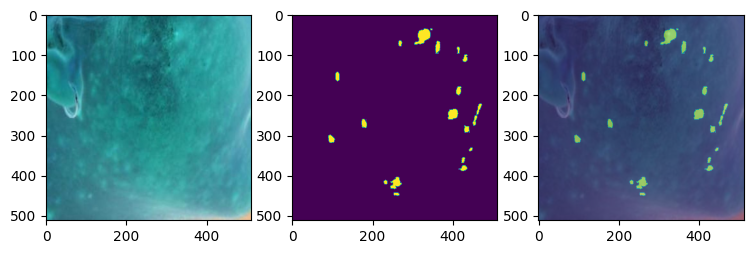

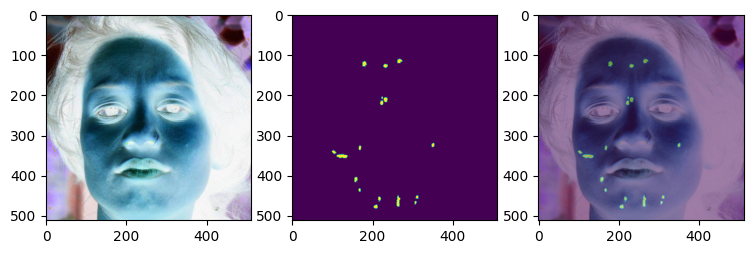

In [14]:
sample_ids = [random.randint(0, len(train_images)) for _ in range(5)]
for sample_id in sample_ids:
    img, msk = train_dataset[sample_id]
    img = img.permute((1, 2, 0)).numpy()*255.0
    img = img.astype('uint8')
    msk = (msk*255).numpy().astype('uint8')
    plt.figure(figsize=(9, 4))
    plt.axis('off')
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.imshow(img, cmap='bone')
    plt.imshow(msk, alpha=0.5)
    plt.show()

In [15]:
def build_model(backbone, num_classes, device):
    model = smp.Unet(
        encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

In [16]:
model = build_model(CFG.backbone, CFG.num_classes, CFG.device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 140MB/s] 


In [17]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
def criterion(y_pred, y_true):
    if CFG.loss_func == "DiceLoss":
        return DiceLoss(y_pred, y_true)
    elif CFG.loss_func == "BCELoss":
        y_true = y_true.unsqueeze(1)
        return BCELoss(y_pred, y_true)

In [18]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [19]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

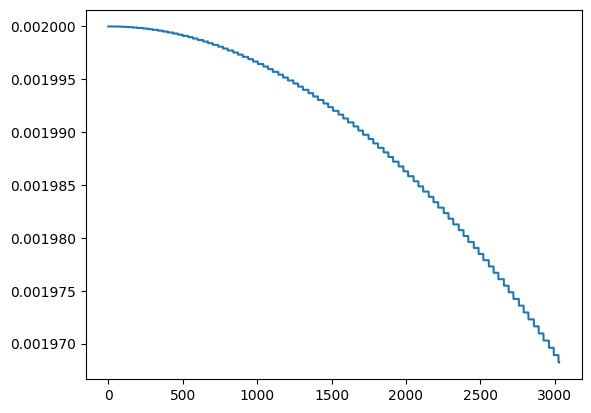

In [20]:
_optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
_scheduler = fetch_scheduler(_optimizer)
lr_list = []
for e in range(CFG.epochs):
    for step in range(len(train_loader)):
        lr_list.append(_optimizer.param_groups[0]['lr'])
        if (step + 1) % CFG.n_accumulate == 0:
            _optimizer.step()
            _scheduler.step()
plt.plot(np.array(range(len(lr_list))), np.array(lr_list))
plt.show()
del _optimizer, _scheduler

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

In [22]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs):    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')
        
        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_epoch.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = "last_epoch.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [24]:
model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)

cuda: Tesla T4



<ipython-input-21-199ad4bbbcf6>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Epoch 1/30

Train :   0%|          | 0/101 [00:00<?, ?it/s]<ipython-input-21-199ad4bbbcf6>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=True):
Valid : 100%|██████████| 51/51 [00:02<00:00, 19.94it/s, gpu_memory=0.41 GB, lr=0.00200, valid_loss=0.9786]


Valid Dice: 0.0284 | Valid Jaccard: 0.0151
Valid Loss: 0.9786117894976747
Valid loss Improved (inf ---> 0.9786117894976747)
Model Saved


Epoch 2/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.54it/s, gpu_memory=0.43 GB, lr=0.00200, valid_loss=0.9751]


Valid Dice: 0.0364 | Valid Jaccard: 0.0197
Valid Loss: 0.9751386034722421
Valid loss Improved (0.9786117894976747 ---> 0.9751386034722421)
Model Saved


Epoch 3/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.22it/s, gpu_memory=0.40 GB, lr=0.00200, valid_loss=0.9768]


Valid Dice: 0.0313 | Valid Jaccard: 0.0169
Valid Loss: 0.9767570367046431


Epoch 4/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.71it/s, gpu_memory=0.47 GB, lr=0.00200, valid_loss=0.9670]


Valid Dice: 0.0728 | Valid Jaccard: 0.0398
Valid Loss: 0.9670017057774114
Valid loss Improved (0.9751386034722421 ---> 0.9670017057774114)
Model Saved


Epoch 5/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.96it/s, gpu_memory=0.46 GB, lr=0.00200, valid_loss=0.9573]


Valid Dice: 0.0963 | Valid Jaccard: 0.0542
Valid Loss: 0.9573474643277187
Valid loss Improved (0.9670017057774114 ---> 0.9573474643277187)
Model Saved


Epoch 6/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 22.70it/s, gpu_memory=0.48 GB, lr=0.00200, valid_loss=0.9506]


Valid Dice: 0.1371 | Valid Jaccard: 0.0780
Valid Loss: 0.9506130160069933
Valid loss Improved (0.9573474643277187 ---> 0.9506130160069933)
Model Saved


Epoch 7/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.00it/s, gpu_memory=0.45 GB, lr=0.00200, valid_loss=0.9401]


Valid Dice: 0.1382 | Valid Jaccard: 0.0768
Valid Loss: 0.9401377451186087
Valid loss Improved (0.9506130160069933 ---> 0.9401377451186087)
Model Saved


Epoch 8/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.49it/s, gpu_memory=0.48 GB, lr=0.00200, valid_loss=0.9208]


Valid Dice: 0.1651 | Valid Jaccard: 0.0949
Valid Loss: 0.9207626464320164
Valid loss Improved (0.9401377451186087 ---> 0.9207626464320164)
Model Saved


Epoch 9/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.50it/s, gpu_memory=0.45 GB, lr=0.00200, valid_loss=0.8995]


Valid Dice: 0.2139 | Valid Jaccard: 0.1282
Valid Loss: 0.899455253984414
Valid loss Improved (0.9207626464320164 ---> 0.899455253984414)
Model Saved


Epoch 10/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.36it/s, gpu_memory=0.48 GB, lr=0.00200, valid_loss=0.8835]


Valid Dice: 0.2518 | Valid Jaccard: 0.1596
Valid Loss: 0.8834791908077165
Valid loss Improved (0.899455253984414 ---> 0.8834791908077165)
Model Saved


Epoch 11/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.67it/s, gpu_memory=0.48 GB, lr=0.00200, valid_loss=0.8584]


Valid Dice: 0.2412 | Valid Jaccard: 0.1531
Valid Loss: 0.8583568089148578
Valid loss Improved (0.8834791908077165 ---> 0.8583568089148578)
Model Saved


Epoch 12/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.32it/s, gpu_memory=0.46 GB, lr=0.00199, valid_loss=0.8386]


Valid Dice: 0.2554 | Valid Jaccard: 0.1612
Valid Loss: 0.8386057393223632
Valid loss Improved (0.8583568089148578 ---> 0.8386057393223632)
Model Saved


Epoch 13/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 22.83it/s, gpu_memory=0.48 GB, lr=0.00199, valid_loss=0.7860]


Valid Dice: 0.2911 | Valid Jaccard: 0.1914
Valid Loss: 0.7859545770813438
Valid loss Improved (0.8386057393223632 ---> 0.7859545770813438)
Model Saved


Epoch 14/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 25.11it/s, gpu_memory=0.46 GB, lr=0.00199, valid_loss=0.8068]


Valid Dice: 0.2410 | Valid Jaccard: 0.1544
Valid Loss: 0.8067767012353037


Epoch 15/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 22.66it/s, gpu_memory=0.52 GB, lr=0.00199, valid_loss=0.8332]


Valid Dice: 0.1957 | Valid Jaccard: 0.1267
Valid Loss: 0.8332116486979466


Epoch 16/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.82it/s, gpu_memory=0.55 GB, lr=0.00199, valid_loss=0.7799]


Valid Dice: 0.2428 | Valid Jaccard: 0.1587
Valid Loss: 0.779906271719465
Valid loss Improved (0.7859545770813438 ---> 0.779906271719465)
Model Saved


Epoch 17/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 22.85it/s, gpu_memory=0.48 GB, lr=0.00199, valid_loss=0.7501]


Valid Dice: 0.2615 | Valid Jaccard: 0.1647
Valid Loss: 0.7500906411339255
Valid loss Improved (0.779906271719465 ---> 0.7500906411339255)
Model Saved


Epoch 18/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.44it/s, gpu_memory=0.48 GB, lr=0.00199, valid_loss=0.7906]


Valid Dice: 0.2147 | Valid Jaccard: 0.1301
Valid Loss: 0.7906077340537426


Epoch 19/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.05it/s, gpu_memory=0.48 GB, lr=0.00199, valid_loss=0.7715]


Valid Dice: 0.2376 | Valid Jaccard: 0.1564
Valid Loss: 0.7715188486903322


Epoch 20/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.24it/s, gpu_memory=0.50 GB, lr=0.00199, valid_loss=0.8022]


Valid Dice: 0.2047 | Valid Jaccard: 0.1327
Valid Loss: 0.8022380167362737


Epoch 21/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.28it/s, gpu_memory=0.51 GB, lr=0.00198, valid_loss=0.7904]


Valid Dice: 0.2162 | Valid Jaccard: 0.1412
Valid Loss: 0.7904490828514099


Epoch 22/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.44it/s, gpu_memory=0.52 GB, lr=0.00198, valid_loss=0.7956]


Valid Dice: 0.2093 | Valid Jaccard: 0.1355
Valid Loss: 0.7955969326636371


Epoch 23/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.46it/s, gpu_memory=0.48 GB, lr=0.00198, valid_loss=0.7705]


Valid Dice: 0.2328 | Valid Jaccard: 0.1474
Valid Loss: 0.7704941840732799


Epoch 24/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.54it/s, gpu_memory=0.47 GB, lr=0.00198, valid_loss=0.7535]


Valid Dice: 0.2501 | Valid Jaccard: 0.1607
Valid Loss: 0.7535182401245716


Epoch 25/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.53it/s, gpu_memory=0.48 GB, lr=0.00198, valid_loss=0.8419]


Valid Dice: 0.1596 | Valid Jaccard: 0.0972
Valid Loss: 0.8418791013605454


Epoch 26/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.90it/s, gpu_memory=0.50 GB, lr=0.00198, valid_loss=0.8177]


Valid Dice: 0.1853 | Valid Jaccard: 0.1121
Valid Loss: 0.8176862854583591


Epoch 27/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.69it/s, gpu_memory=0.52 GB, lr=0.00197, valid_loss=0.7893]


Valid Dice: 0.2119 | Valid Jaccard: 0.1334
Valid Loss: 0.7893207131647596


Epoch 28/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.69it/s, gpu_memory=0.52 GB, lr=0.00197, valid_loss=0.7917]


Valid Dice: 0.2115 | Valid Jaccard: 0.1354
Valid Loss: 0.791723719998902


Epoch 29/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 23.97it/s, gpu_memory=0.48 GB, lr=0.00197, valid_loss=0.7294]


Valid Dice: 0.2735 | Valid Jaccard: 0.1735
Valid Loss: 0.7294017988092759
Valid loss Improved (0.7500906411339255 ---> 0.7294017988092759)
Model Saved


Epoch 30/30

Valid : 100%|██████████| 51/51 [00:02<00:00, 24.28it/s, gpu_memory=0.48 GB, lr=0.00197, valid_loss=0.7648]


Valid Dice: 0.2362 | Valid Jaccard: 0.1526
Valid Loss: 0.7648063337101656


Training complete in 0h 7m 46s
Best Loss: 0.7294


In [25]:
def visualize_prediction_with_rows(model, image_path, mask_path, transform, device, threshold=0.5):
    """
    Visualize original and transformed images, masks, and overlays in two rows.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        image_path (str): Path to the input image.
        mask_path (str): Path to the corresponding ground truth mask.
        transform (albumentations.Compose): Transformation to apply to the image and mask.
        device (torch.device): Device (CPU or CUDA).
        threshold (float): Threshold for binary segmentation (default is 0.5).

    Returns:
        None
    """
    # Load the original image and mask
    img = np.array(Image.open(image_path).convert("RGB"))
    msk = np.array(Image.open(mask_path))

    # Apply transformations to get the "new" versions
    transformed = transform(image=img, mask=msk)
    transformed_img = transformed['image']
    transformed_msk = transformed['mask']
    img_tensor = torch.tensor(transformed_img).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Run the model to predict the mask
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)  # Forward pass
        if pred.shape[1] == 1:  # Binary segmentation
            pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_mask = (pred_mask > threshold).astype("uint8")
        else:  # Multiclass segmentation
            pred_mask = torch.argmax(pred.squeeze(0), dim=0).cpu().numpy()

    # Debugging
    print("Predicted Mask Shape:", pred_mask.shape)
    print("Unique Values in Predicted Mask:", np.unique(pred_mask))

    # Create overlays
    overlay_original = img.copy()
    overlay_transformed = transformed_img.copy()

    # Overlay original mask in green
    overlay_original[msk > 0] = [0, 255, 0]

    # Overlay predicted mask in red
    overlay_transformed[pred_mask > 0] = [255, 0, 0]

    # Visualize results
    plt.figure(figsize=(20, 12))

    # Row 1: Original Image, Original Mask, Original Overlay
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(msk, cmap="gray")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(overlay_original)
    plt.title("Original Overlay")
    plt.axis("off")

    # Row 2: Transformed Image, Transformed Mask, Transformed Overlay
    plt.subplot(2, 3, 4)
    plt.imshow(transformed_img.astype("uint8"))
    plt.title("Transformed Image")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(transformed_msk, cmap="gray")
    plt.title("Transformed Mask")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(overlay_transformed.astype("uint8"))
    plt.title("Transformed Overlay (Prediction)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Predicted Mask Shape: (512, 512)
Unique Values in Predicted Mask: [0 1]


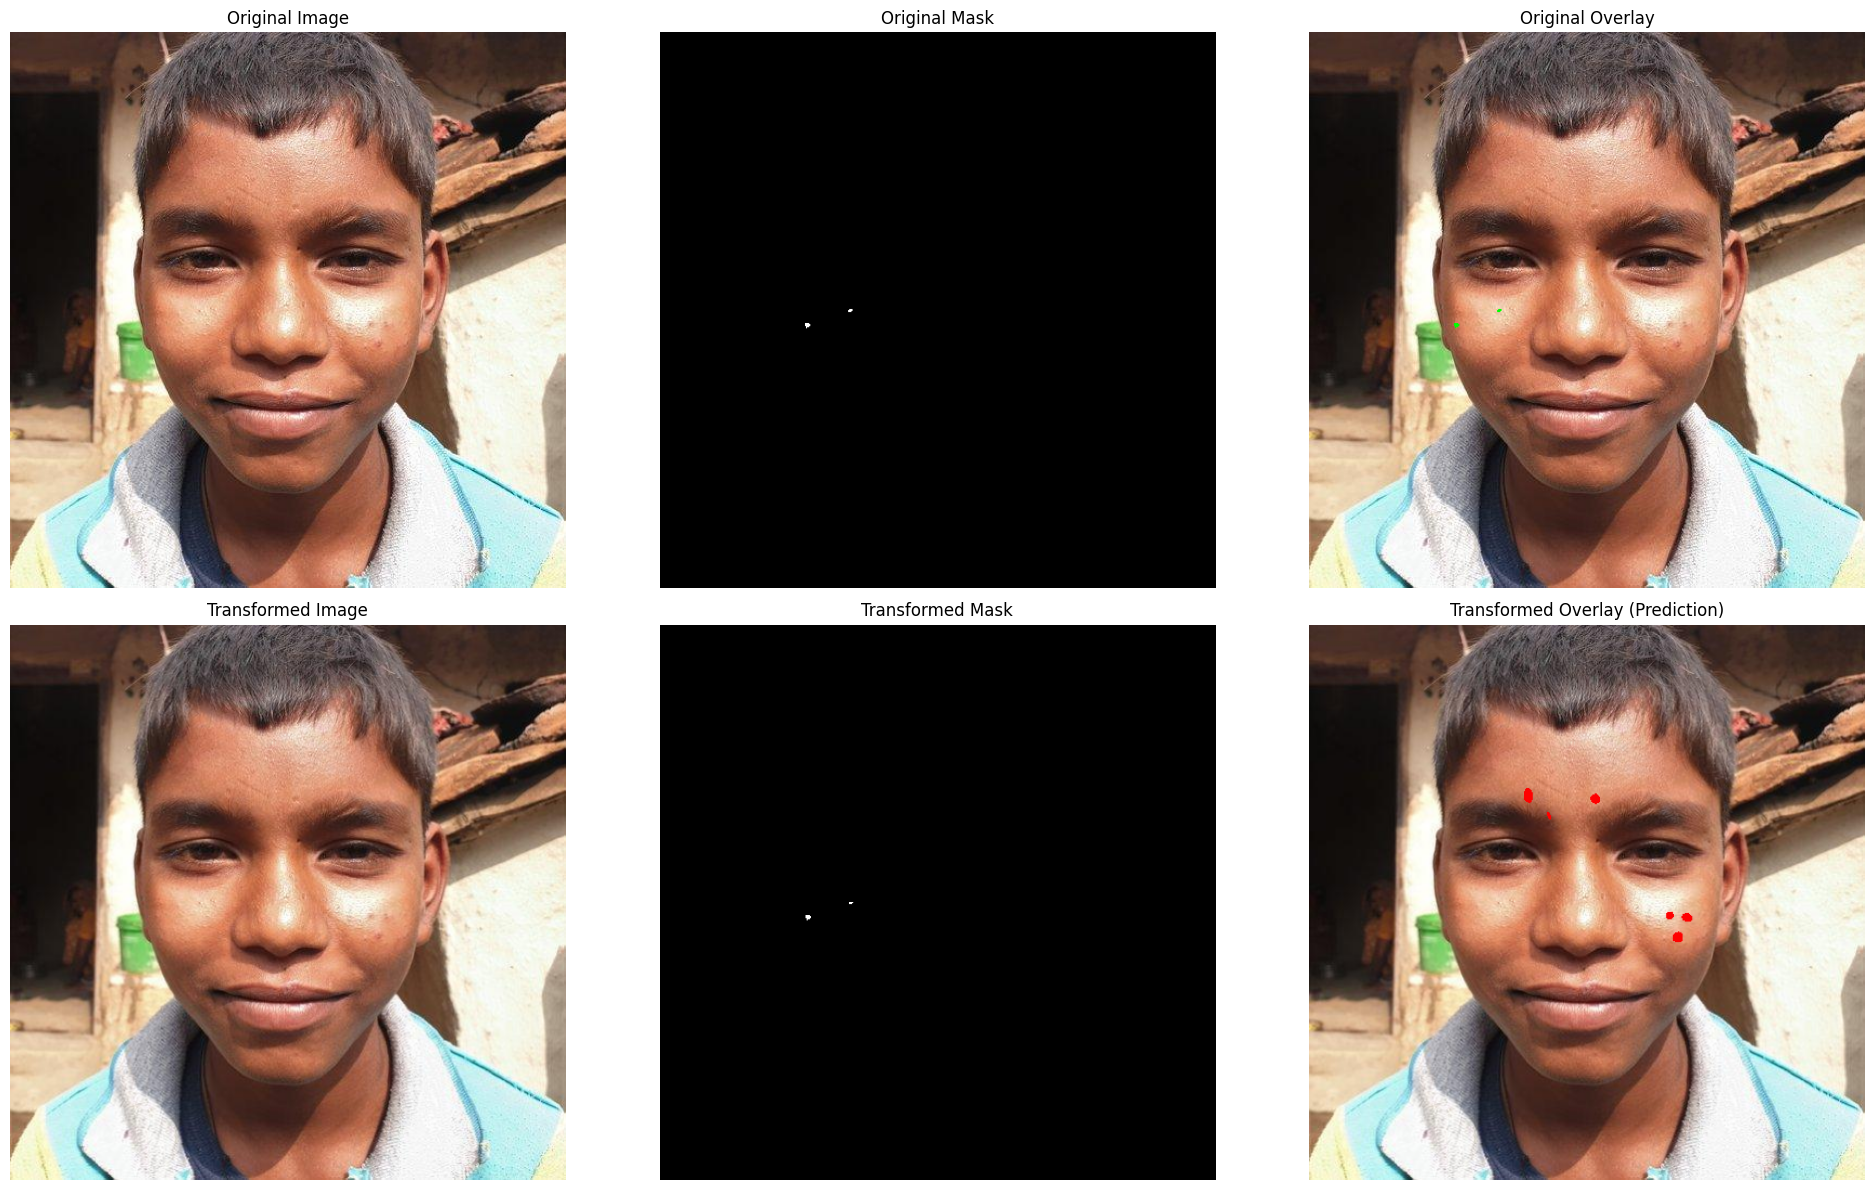

In [26]:

image_path = valid_images[12]  # Replace with a path to an image
mask_path = valid_masks[12]    # Replace with a path to the corresponding mask
visualize_prediction_with_rows(model, image_path, mask_path, CFG.data_transforms["valid"], CFG.device)


In [27]:
torch.save(model.state_dict(), "weights/model_weights.pth")